# Pareto Frontiers for Toggling, Adjoint, and Universal Robustness Objectives (Robustness & Fidelity Trade-off)


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [2]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
add_var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)

mult_var_sys = VariationalQuantumSystem(
    a -> a[1] * PAULIS.X + a[2] * PAULIS.Y + a[3] * PAULIS.Z,
    Function[a -> a[1] * PAULIS.X, a -> a[2] * PAULIS.Y, a -> a[3] * PAULIS.Z],
    1
)


VariationalQuantumSystem: levels = 2, n_drives = 3

### Pareto Frontiers + Penalty Plots

In [3]:
n_guesses = 3
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []
n_seeds = n_guesses


for i in 1:n_seeds
    Random.seed!(1234+i)
    a_bounds = fill(1.0, n_drives)
    da_bounds = fill(1.0, n_drives)
    # da_bounds = fill((5.5+0.5*i)*π*Δt/T, n_drives)
    dda_bounds = fill(10^(1.0-i), n_drives)
    control_bounds = (a_bounds, da_bounds, dda_bounds)
    traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(seeds, traj)
end



In [4]:
a_vals = exp.(range(log(100), log(100000), length=6))
final_fid_floor_log = 1 .- 1 ./ a_vals
final_fid_floor = final_fid_floor_log

n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

init_def_fids = zeros(n_seeds, n_nines)
init_var_fids = zeros(n_seeds, n_nines)
init_tog_fids = zeros(n_seeds, n_nines)
init_uni_fids = zeros(n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for j in 1:n_nines
        Random.seed!(1234+i)
        # default case (no robustness)
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        # variational objective
        var_prob = UnitaryVariationalProblem(var_sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), robust_times=[[T], [T], [T]], Q_r=1.0, piccolo_options=piccolo_opts)
        init_var_probs[i, j] = var_prob
        var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
        init_var_fids[i,j] = var_fid

        # toggling objective
        tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_rob_loss=true, H_err=Hₑ_add, Q_t=0.1)
        init_tog_probs[i, j] = tog_prob
        tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
        init_tog_fids[i,j] = tog_fid

        # universal objective
        uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_hyperspeed=true)
        init_uni_probs[i, j] = uni_prob
        uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
        init_uni_fids[i,j] = uni_fid

    end
end

for i in 1:n_seeds
    for j in 1:n_nines
        
        takes = 1
        while takes < 100 && init_var_fids[i,j] < final_fid_floor[j]
            solve!(init_var_probs[i, j]; max_iter=5, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
            init_var_fids[i,j] = init_var_fid
            takes += 1
        end
        
        takes = 1
        while takes < 100 && init_tog_fids[i,j] < final_fid_floor[j]
            solve!(init_tog_probs[i, j]; max_iter=5, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
            init_tog_fids[i,j] = init_tog_fid
            takes += 1
        end

        takes = 1
        while takes < 100 && init_uni_fids[i,j] < final_fid_floor[j]
            solve!(init_uni_probs[i, j]; max_iter=5, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
            init_uni_fids[i,j] = init_uni_fid
            takes += 1
        end

        takes = 1
        while takes < 150 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=5, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

    end
end



    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using i

Initial Fidelity Summary Table

In [5]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(init_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(init_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(init_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |      0.99995 |     0.996487 |      0.998875 |      0.998551 |"

"0.99999 |          1.0 |     0.999999 |      0.999996 |      0.999999 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999517 |      0.51128 |      0.998898 |      0.999222 |"

"0.99999 |     0.999992 |      0.51128 |      0.999999 |      0.999992 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999833 |     0.004851 |      0.999841 |      0.994082 |"

"0.99999 |     0.999999 |     0.004851 |      0.999996 |      0.934493 |"

Solve Max-Toggle Problems

In [6]:
n_nines = length(final_fid_floor)
final_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

Hₑ_add = a -> PAULIS.X + PAULIS.Y + PAULIS.Z

for i in 1:n_seeds
    for j in 1:n_nines

        var_prob = UnitaryVariationalProblem(
                var_sys,  U_goal, T, Δt;
                robust_times=[[T], [T], [T]],
                Q=0.0,
                Q_r=1.0,
                init_trajectory=init_var_probs[i,j].trajectory,
                var_seed=false,
                piccolo_options=piccolo_opts
            )
        F = final_fid_floor[j]
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        solve!(var_prob, max_iter=75, print_level=5)
        final_var_probs[i,j] = var_prob

        tog_prob = UnitaryMaxToggleProblem(
                init_tog_probs[i,j],
                U_goal,
                Hₑ_add;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(tog_prob, max_iter=75, print_level=5)
        final_tog_probs[i,j] = tog_prob

        uni_prob = UnitaryMaxUniversalProblem(
                init_uni_probs[i,j],
                U_goal;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(uni_prob, max_iter=75, print_level=5)
        final_uni_probs[i,j] = uni_prob


        # X_drive = sys.H.H_drives[1]
        # Hₑ_mult = a -> a[1] * X_drive

        # mult_prob = UnitaryMaxToggleProblem(
        #         warm_mult_probs[i,j],
        #         U_goal,
        #         Hₑ_mult;
        #         Q_t=1.0,
        #         final_fidelity=final_fid_floor[j],
        #         piccolo_options=piccolo_opts
        #     )
        # solve!(mult_prob, max_iter=75, print_level=5)
        # final_mult_probs[i,j] = mult_prob

        
        # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
        # both_prob = UnitaryToggleProblem(
        #     sys, U_goal, T, Δt, Hₑ_both;
        #     piccolo_options=piccolo_opts
        #     )
        # solve!(both_prob, max_iter=150, print_level=5)

    end
end



    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: initial value of Ũ⃗ᵥ3
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:    46064
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:     3305

Total number of variables............................:     1642
                     variables with only lower bounds:        0
                variables with lower and upper bounds

In [17]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(final_var_probs[seed_idx, j].trajectory, sys)
            tog_fid = unitary_rollout_fidelity(final_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(final_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |      0.99995 |     0.990808 |      0.996124 |      0.991681 |"

"0.99999 |          1.0 |     0.999999 |           1.0 |      0.999998 |"

"\nseed idx = 2:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999517 |         0.99 |      0.992372 |      0.992052 |"

"0.99999 |     0.999992 |      0.99999 |           1.0 |           1.0 |"

"\nseed idx = 3:"

"Final f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999833 |         0.99 |      0.990009 |      0.990073 |"

"0.99999 |     0.999999 |     0.830625 |       0.99999 |      0.999992 |"

Pareto Frontiers

sorted by fidelity min

In [ ]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    final_point = curve[end]
    return norm(final_point)
end


space_curve_robustness (generic function with 1 method)

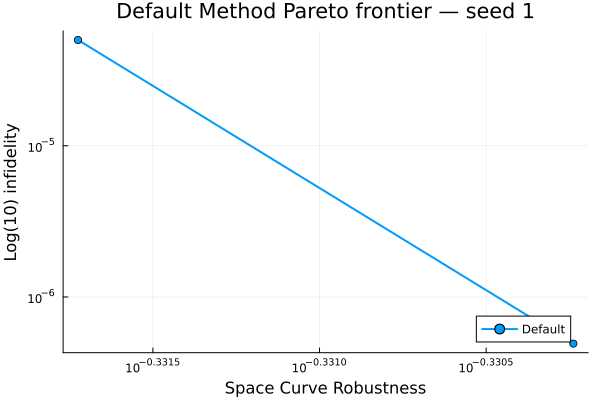

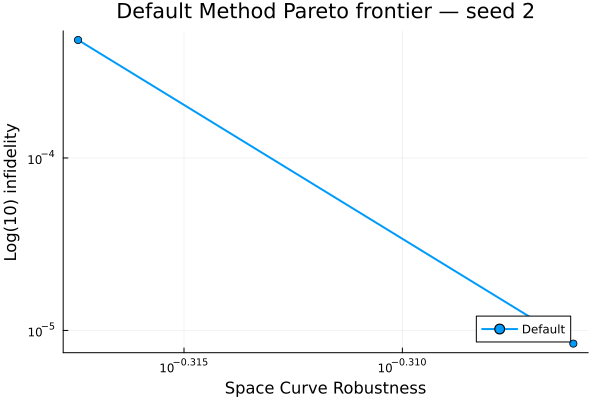

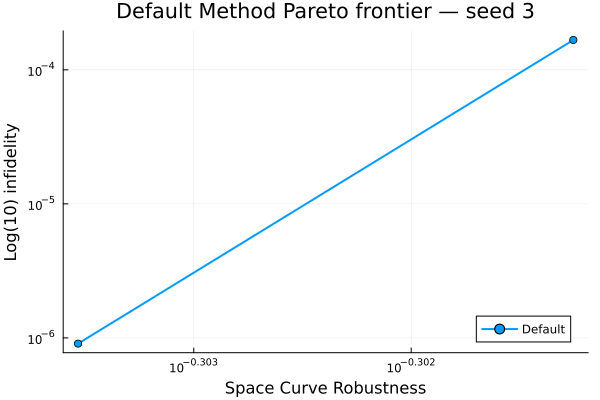

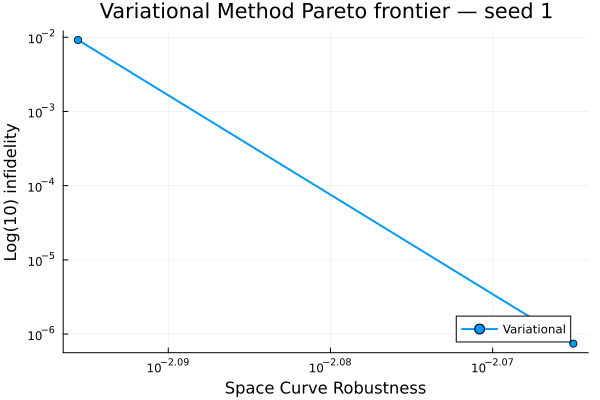

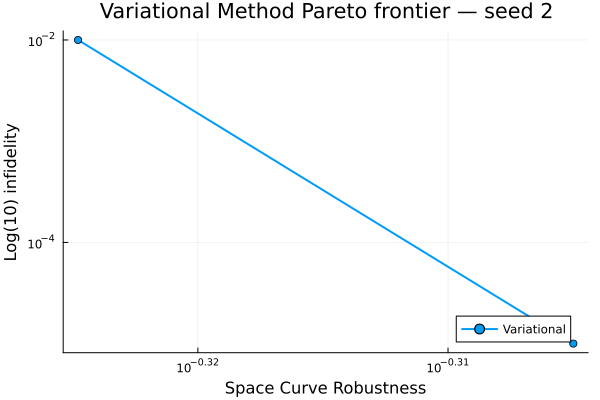

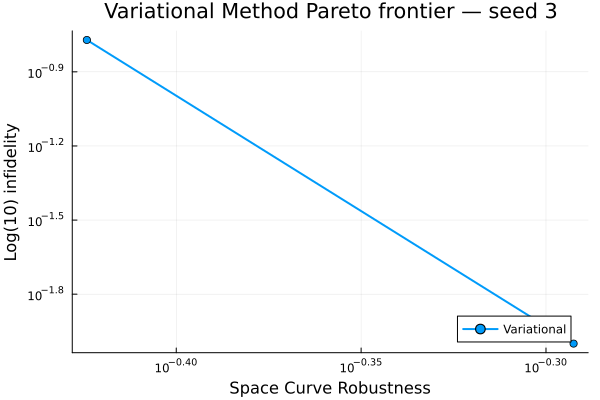

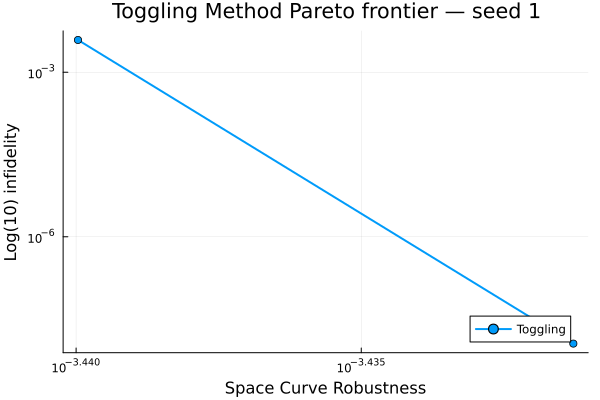

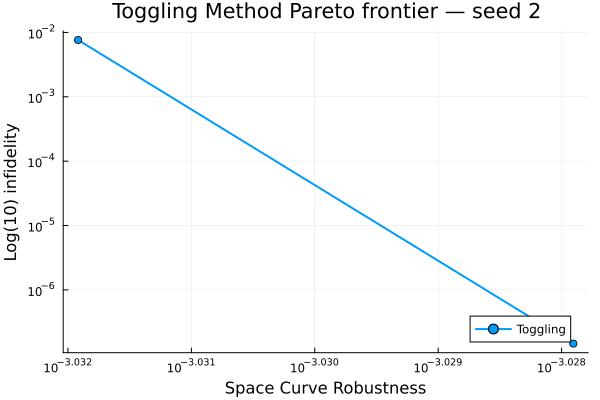

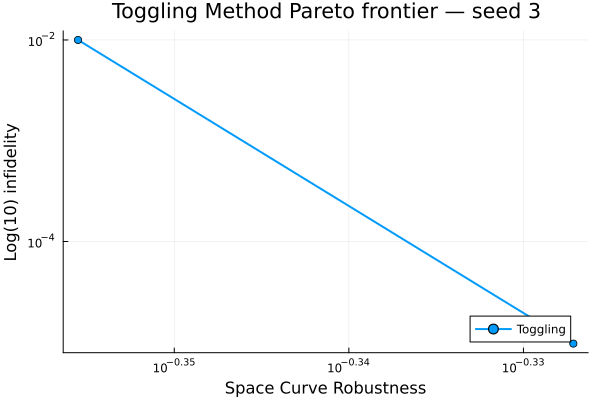

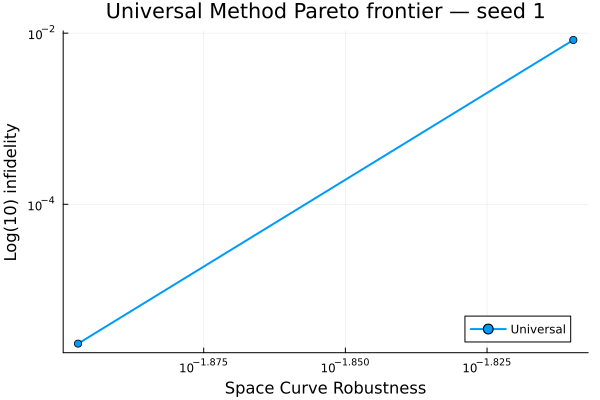

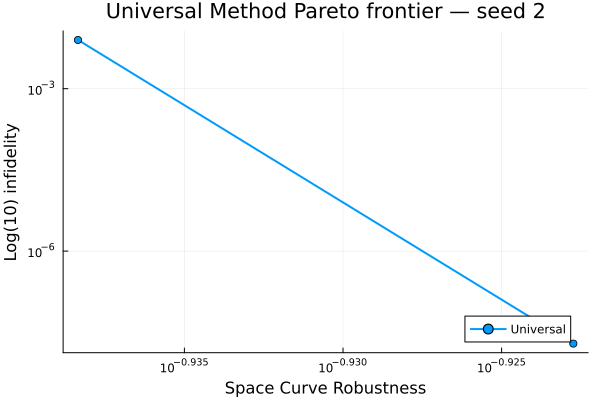

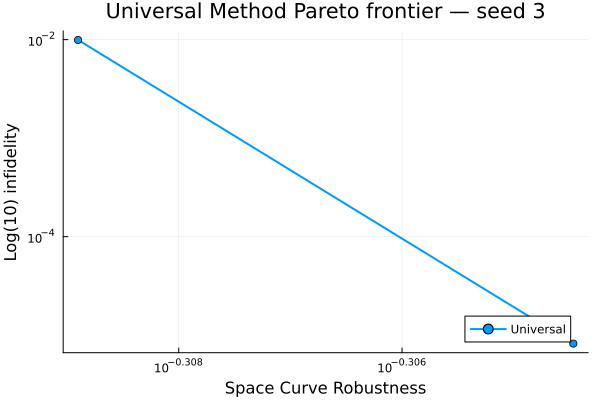

In [16]:
H_err_add = (PAULIS.X + PAULIS.Y + PAULIS.Z) / 3  # For variational and toggling methods

# Modified plotting code
arr_probs = [default_probs, final_var_probs, final_tog_probs, final_uni_probs]
method_names = ["Default", "Variational", "Toggling", "Universal"]

for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]
    # H_err = H_err_list[prob_idx]
    
    for s in 1:n_seeds
        plt = Plots.plot(
            xlabel="Space Curve Robustness",
            ylabel="Log(10) infidelity", 
            title="$method_name Method Pareto frontier — seed $s",
            xscale = :log10, yscale = :log10,
            legend=:bottomright, grid=true,
            # yflip=true
        )
        
        xs = Float64[]  # robustness from space curve
        ys = Float64[]  # infidelity
        
        for (j, f) in enumerate(final_fid_floor)
            prob = probs[s, j]
            
            # Compute robustness using space curve
            robustness = space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            
            infidelity = 1 - unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(xs, robustness)
            push!(ys, infidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(xs)
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=method_name, linewidth=2)
        display(plt)
    end
end


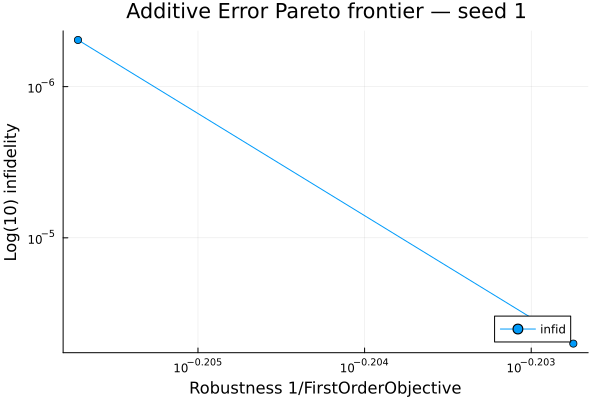

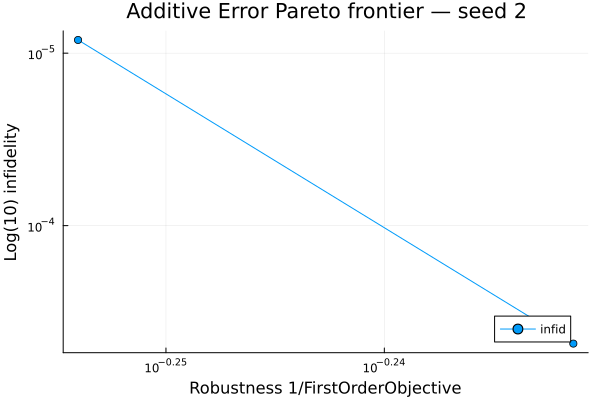

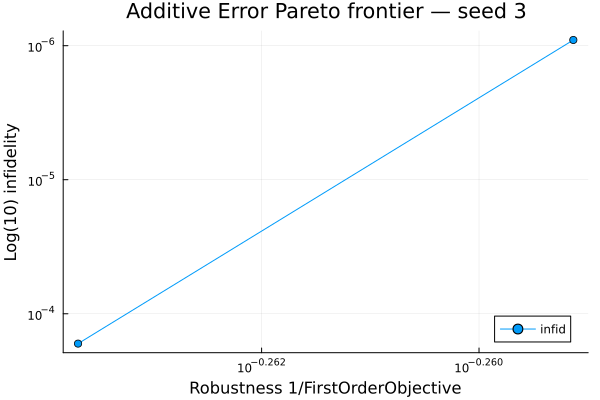

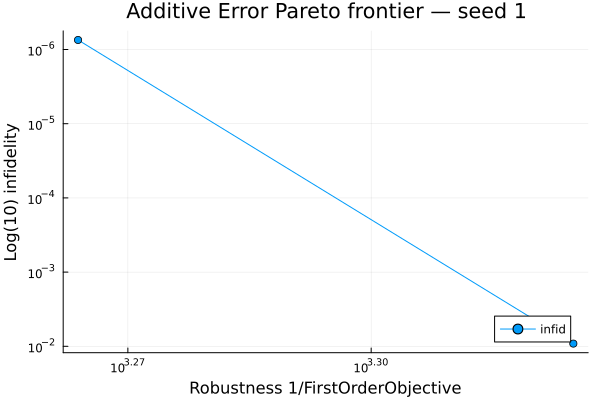

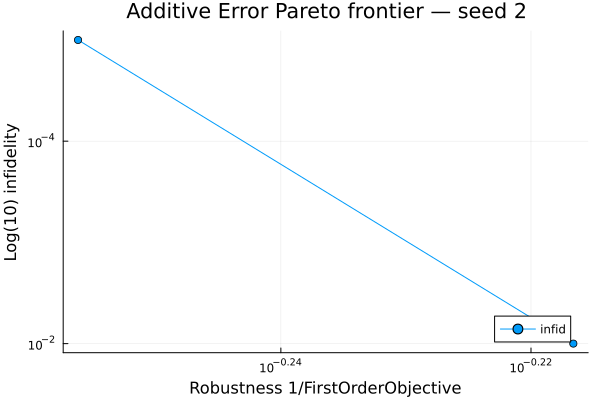

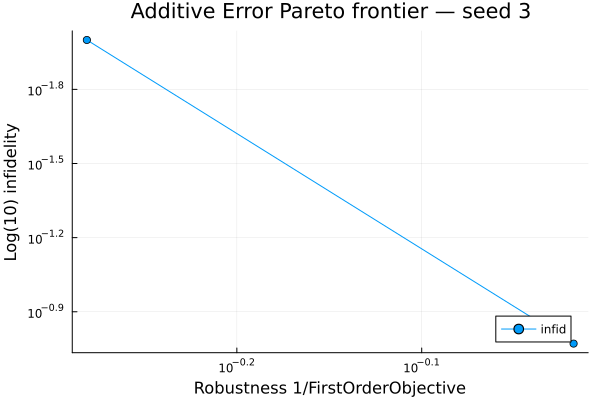

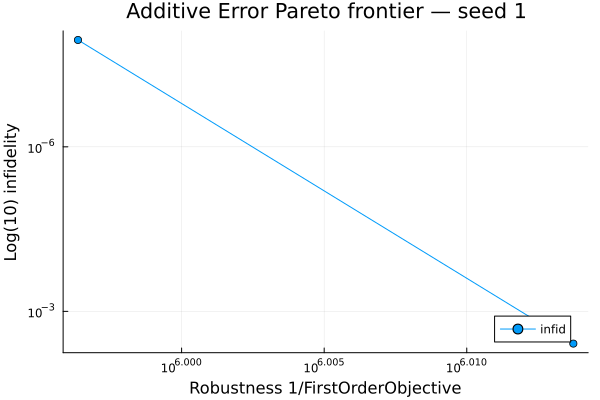

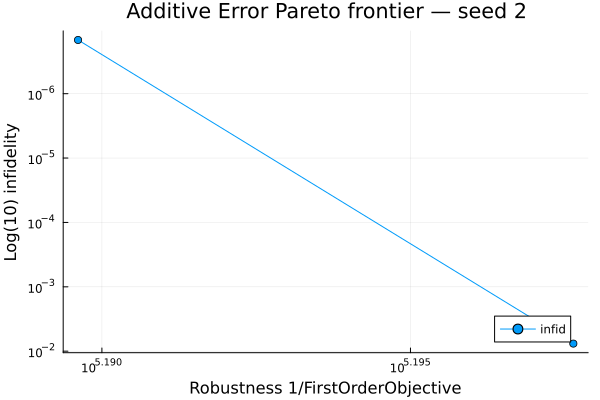

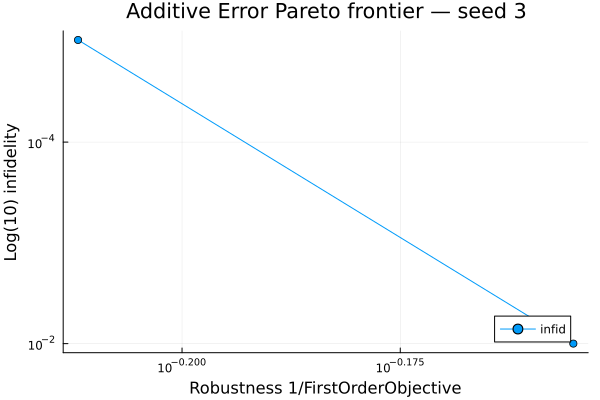

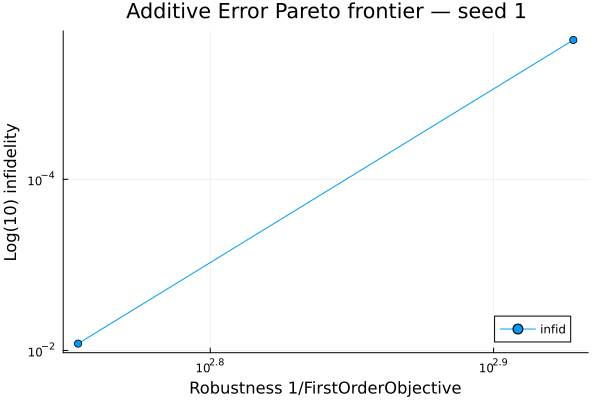

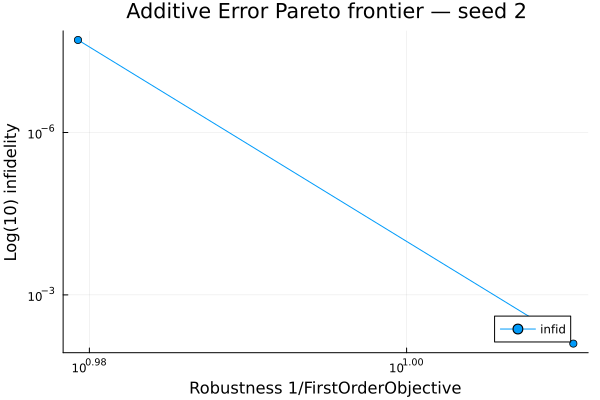

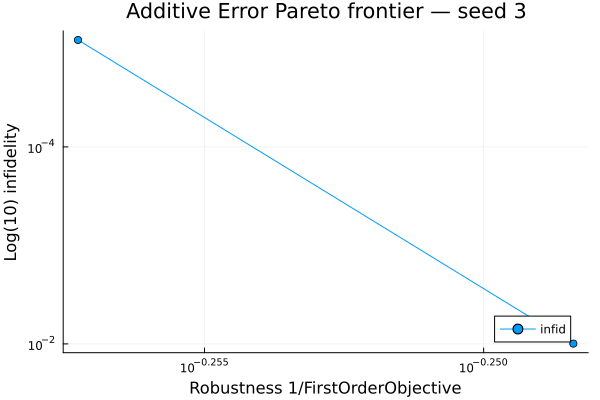

In [13]:
arr_probs = [default_probs, final_var_probs, final_tog_probs, final_uni_probs]

for probs in arr_probs
    for s in 1:n_seeds
        plt = Plots.plot(
            xlabel="Robustness 1/FirstOrderObjective",
            ylabel="Log(10) infidelity",
            title="Additive Error Pareto frontier — seed $s",
            xscale = :log10, yscale = :log10,
            legend=:bottomright, grid=true,
            yflip=true
        )
        xs = Float64[]
        ys = Float64[]
        for (j, f) in enumerate(final_fid_floor)
            prob = probs[s, j]
            obj = FirstOrderObjective(Hₑ_add, prob.trajectory)
            # UN_obj = TurboUniversalObjective(prob.trajectory)
            Z_vec = vec(prob.trajectory)    
            obj_val = 1/obj.L(Z_vec)
            push!(xs, obj_val)
            push!(ys, 1-unitary_rollout_fidelity(prob.trajectory, sys))
        end
        # sort by x for a nice line
        ord = sortperm(xs)
        name = "infid"
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=name)
        display(plt)
    end
end

    
# for s in 1:n_seeds
#     plt = Plots.plot(
#         xlabel="Robustness 1/FirstOrderObjective",
#         ylabel="Log(10) infidelity",
#         title="Additive Error Pareto frontier — seed $s",
#         xscale = :log10, yscale = :log10,
#         legend=:bottomright, grid=true,
#         yflip=true
#     )
#     xs = Float64[]
#     ys = Float64[]
#     for (j, f) in enumerate(final_fid_floor)
#         add_prob = final_add_probs[s, j]
#         Hₑ_add = a -> PAULIS.X
#         obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
#         Z_vec = vec(add_prob.trajectory)
#         obj_val = 1/obj.L(Z_vec)
#         push!(xs, obj_val)
#         push!(ys, 1-unitary_rollout_fidelity(add_prob.trajectory, sys))
#     end
#     # sort by x for a nice line
#     # ord = sortperm(xs)
#     name = "infid"
#     Plots.plot!(plt, xs, ys, marker=:circle, label=name)
#     display(plt)
# end

# for s in 1:n_seeds
#     plt = Plots.plot(
#         xlabel="Robustness 1/FirstOrderObjective",
#         ylabel="Log(10) infidelity",
#         title="Multiplicative Error Pareto frontier — seed $s",
#         legend=:bottomright, grid=true,
#         xscale = :log10, yscale = :log10,
#         yflip=true
#     )
#     xs = Float64[]  # robustness
#     ys = Float64[]  # fidelity
#     for (j, f) in enumerate(final_fid_floor)
#         mult_prob = final_mult_probs[s, j]
#         X_drive = sys.H.H_drives[1]
#         Hₑ_mult = a -> a[1] * X_drive
#         obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
#         Z_vec = vec(mult_prob.trajectory)
#         obj_val = 1/obj.L(Z_vec)
#         push!(xs, obj_val)
#         push!(ys, 1-unitary_rollout_fidelity(mult_prob.trajectory, sys))
#     end
#     # sort by x for a nice line
#     # ord = sortperm(xs)
#     name = "infid"
#     Plots.plot!(plt, xs, ys, marker=:circle, label=String(name))
#     display(plt)
# end

Penalty

In [ ]:
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=10))
n_lambdas = length(sweep_rob_loss_λ)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

Hₑ_add = a -> PAULIS.X + PAULIS.Y + PAULIS.Z
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ) 

        # var problem
        var_prob = UnitarySmoothPulseProblem(
            var_sys, U_goal, T, Δt;
            init_trajectory=deepcopy(init_var_probs[i,j].trajectory),
            piccolo_options=piccolo_opts,
            var_seed=false,
            Q_r=λ
        )
        solve!(var_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob; max_iter=50, print_level=5)
        pen_var_probs[i, λ_idx] = var_prob

        # tog problem
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=λ
        )
        solve!(tog_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob; max_iter=50, print_level=5)
        pen_tog_probs[i, λ_idx] = tog_prob

        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            Q_t=λ
        )
        solve!(uni_prob; max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob; max_iter=50, print_level=5)
        pen_uni_probs[i, λ_idx] = uni_prob
    end
end


### Full Plots

In [ ]:
function compute_space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    """Compute the average norm of the space curve over Pauli X, Y, Z"""
    space_curve = SpaceCurve(traj, U_goal, H_err)
    
    # Extract X, Y, Z components for each time step
    x_components = [sc[1] for sc in space_curve]
    y_components = [sc[2] for sc in space_curve]
    z_components = [sc[3] for sc in space_curve]
    
    # Compute norms for each Pauli direction
    x_norm = norm(x_components)
    y_norm = norm(y_components)
    z_norm = norm(z_components)
    
    # Return average norm
    return (x_norm + y_norm + z_norm) / 3.0
end

#### pareto with penalty

In [ ]:
# Define colors for methods
method_colors = [:blue, :red, :green]
method_names_plot = ["Variational", "Toggling", "Universal"]

H_err_add = PAULIS.X + PAULIS.Y + PAULIS.Z

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    fig = Figure(resolution=(800, 600))
    ax = Axis(fig[1, 1], 
             xlabel="Average Space Curve Robustness", 
             ylabel="Fidelity",
             title="$method_name Method: Pareto Frontier and Penalty Points")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Plot for each seed
    for s in 1:n_seeds
        # Pareto frontier points
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(pareto_x, robustness)
            push!(pareto_y, fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=method_colors[method_idx], linewidth=2, 
               label=s == 1 ? "Pareto Frontier" : "")
        scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=method_colors[method_idx], markersize=8)
        
        # Penalty points
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(penalty_x, robustness)
            push!(penalty_y, fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label=s == 1 ? "Penalty Points" : "")
    end
    
    # Add colorbar for lambda values
    Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
             colormap=:viridis, label="λ value")
    
    axislegend(ax, position=:lb)
    display(fig)
end



#### comparing pareto frontiers of objectives

In [ ]:
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Pareto Frontiers Comparison: All Methods")

pareto_arrays = [final_var_probs, final_tog_probs, final_uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    pareto_probs = pareto_arrays[method_idx]
    
    # Collect all points for this method across all seeds
    all_x = Float64[]
    all_y = Float64[]
    
    for s in 1:n_seeds
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, robustness)
            push!(all_y, fidelity)
        end
    end
    
    # Sort by x-axis for smooth line
    ord = sortperm(all_x)
    lines!(ax, all_x[ord], all_y[ord], 
           color=method_colors[method_idx], linewidth=3, 
           label=method_name)
    scatter!(ax, all_x[ord], all_y[ord], 
            color=method_colors[method_idx], markersize=8)
end

axislegend(ax, position=:lb)
display(fig)



### comparing penalty method performace of objective

In [ ]:
fig = Figure(resolution=(800, 600))
ax = Axis(fig[1, 1], 
         xlabel="Average Space Curve Robustness", 
         ylabel="Fidelity",
         title="Penalty Points Comparison: All Methods")

penalty_arrays = [pen_var_probs, pen_tog_probs, pen_uni_probs]

for (method_idx, method_name) in enumerate(method_names_plot)
    penalty_probs = penalty_arrays[method_idx]
    
    # Collect all points for this method across all seeds and lambdas
    all_x = Float64[]
    all_y = Float64[]
    all_lambda = Float64[]
    
    for s in 1:n_seeds
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(all_x, robustness)
            push!(all_y, fidelity)
            push!(all_lambda, λ)
        end
    end
    
    # Use different color schemes for each method to distinguish them
    colormap = [:Blues, :Reds, :Greens][method_idx]
    scatter!(ax, all_x, all_y, 
            color=all_lambda, colormap=colormap, markersize=8,
            label=method_name)
end

# Create custom colorbar showing lambda range
Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
         colormap=:viridis, label="λ value")

axislegend(ax, position=:lb)
display(fig)

println("All plots completed!")

# Optional: Save plots
# save("pareto_comparison.png", fig)



In [ ]:
# Summary statistics
println("\nSummary Statistics:")
println("==================")

for (method_idx, method_name) in enumerate(method_names_plot)
    println("\n$method_name Method:")
    
    if method_idx == 1
        probs = final_var_probs
    elseif method_idx == 2
        probs = final_tog_probs
    else
        probs = final_uni_probs
    end
    
    robustness_vals = Float64[]
    fidelity_vals = Float64[]
    
    for s in 1:n_seeds, j in 1:n_nines
        prob = probs[s, j]
        robustness = compute_space_curve_robustness(prob.trajectory, U_goal, H_err_add)
        fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
        
        push!(robustness_vals, robustness)
        push!(fidelity_vals, fidelity)
    end
    
    println("  Robustness range: $(round(minimum(robustness_vals), digits=6)) - $(round(maximum(robustness_vals), digits=6))")
    println("  Fidelity range: $(round(minimum(fidelity_vals), digits=6)) - $(round(maximum(fidelity_vals), digits=6))")
    println("  Mean robustness: $(round(mean(robustness_vals), digits=6))")
    println("  Mean fidelity: $(round(mean(fidelity_vals), digits=6))")
end

### sanity checks 

Final Fidelity Table

In [12]:
# H_drive_add = H_drive
# εs = 0:0.005:0.2
# # colors = Makie.wong_colors()

# # Get fid for each problem
# for seed_idx in 1:n_seeds
#     display("\nseed idx = $seed_idx:")
#     display("Final f | Base Fidelity | Add Fidelity | Mult Fidelity ")
#     display("-" ^ 40)
#     for (j, f) in enumerate(final_fid_floor)
#             def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
#             add_fid = unitary_rollout_fidelity(final_add_probs[seed_idx, j].trajectory, sys)
#             mult_fid = unitary_rollout_fidelity(final_mult_probs[seed_idx, j].trajectory, sys)
#             display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
#     end
# end

Plot Fidelity vs Error

In [13]:
# εs     = 0:0.01:0.5
# floors = final_fid_floor

# # Build a continuous colormap and a normalizer for the floor values
# cmap   = cgrad(:viridis)  # perceptually uniform
# fmin, fmax = extrema(floors)
# nfloor(x) = fmax == fmin ? 0.5 : (x - fmin) / (fmax - fmin)  # safeguard for flat ranges

# # Helper: get the color for a given floor
# floor_color(f) = cmap[nfloor(f)]

# # Helper to plot one seed, additive-only
# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         add_traj  = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_add, color=c, linestyle=:solid,
#                label="add toggle @ $(round(f; digits=6))")
#     end

#     # Legend + continuous colorbar keyed to floor
#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end

# # Helper to plot one seed, multiplicative-only
# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         # Base (default) trajectory at this floor
#         def_traj  = default_probs[seed_idx, j].trajectory
#         # Optimized (toggle) trajectory at this floor
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         lines!(ax, εs, ys_def,  color=c, linestyle=:dash,
#                label="base @ $(round(f; digits=6))")
#         lines!(ax, εs, ys_mult, color=c, linestyle=:solid,
#                label="mult toggle @ $(round(f; digits=6))")
#     end

#     axislegend(ax, position=:lb, nbanks=2)
#     Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")

#     fig
# end


In [14]:
# εs     = 0:0.01:0.5
# using Makie: LineElement


# const LINE_ALPHA = 0.8
# const LINEWIDTH  = 1.2
# const YMAX       = 1.0

# function finalize_axes!(fig, ax; cmap, fmin, fmax, ymin_seen)
#     ylo = 0.9#min(0.9, ymin_seen)                   # expand lower only if needed
#     Makie.ylims!(ax, ylo, 1.0)                  # qualify to avoid Plots clash

#     ax.yticks = 0.90:0.02:1.00
#     ax.ytickformat = vals -> string.(round.(vals; digits=2))

#     # Optional grid styling (works if your Makie version exposes these fields):
#     # ax.xgridvisible = true;  ax.ygridvisible = true
#     # ax.xgridcolor   = (:gray, 0.25); ax.ygridcolor = (:gray, 0.25)
#     # ax.xgridwidth   = 0.8;           ax.ygridwidth = 0.8

#     style_elems = [
#         LineElement(color=:black, linestyle=:dash,  linewidth=1.2),
#         LineElement(color=:black, linestyle=:solid, linewidth=1.2),
#     ]
#     Makie.axislegend(ax, style_elems, ["base", "optimized"], position=:lb)
#     Makie.Colorbar(fig[1,2], colormap=cmap, limits=(fmin, fmax), label="Fidelity floor")
# end

# function plot_seed_additive(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — additive error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj = default_probs[seed_idx, j].trajectory
#         add_traj = final_add_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_add = [unitary_rollout_fidelity(
#                       add_traj,
#                       QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]

#         # Track global minimum so we never hide data
#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_add))

#         # Same hue for the pair; dashed = base, solid = optimized
#         lines!(ax, εs, ys_def, color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_add, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end

# function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
#     fig = Figure(resolution=(950,600))
#     ax = Axis(fig[1,1];
#         title = "Seed $(seed_idx) — multiplicative error",
#         xlabel = "ε",
#         ylabel = "Fidelity"
#     )

#     ymin_seen = Inf

#     for j in 1:length(floors)
#         f = floors[j]
#         c = floor_color(f)

#         def_traj  = default_probs[seed_idx, j].trajectory
#         mult_traj = final_mult_probs[seed_idx, j].trajectory

#         ys_def = [unitary_rollout_fidelity(
#                       def_traj,
#                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                   ) for ε in εs]
#         ys_mult = [unitary_rollout_fidelity(
#                        mult_traj,
#                        QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
#                    ) for ε in εs]

#         ymin_seen = min(ymin_seen, minimum(ys_def), minimum(ys_mult))

#         lines!(ax, εs, ys_def,  color=(c, LINE_ALPHA), linestyle=:dash,  linewidth=LINEWIDTH)
#         lines!(ax, εs, ys_mult, color=(c, LINE_ALPHA), linestyle=:solid, linewidth=LINEWIDTH)
#     end

#     finalize_axes!(fig, ax; cmap=cmap, fmin=fmin, fmax=fmax, ymin_seen=ymin_seen)
#     fig
# end


In [15]:
# using JLD2
# using Dates

# # Collect trajectories only (lighter than storing whole problem objects)
# default_trajs    = [default_probs[i, j].trajectory    for i in 1:n_seeds, j in 1:n_nines]
# warm_add_trajs   = [init_var_probs[i, j].trajectory   for i in 1:n_seeds, j in 1:n_nines]
# warm_mult_trajs  = [warm_mult_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_add_trajs  = [final_add_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
# final_mult_trajs = [final_mult_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_nines]

# # Optional: fidelity traces you computed
# fid_traces = Dict(
#     "init_def_fids"  => init_def_fids,
#     "init_add_fids"  => init_add_fids,
#     "init_mult_fids" => init_mult_fids,
# )

# # Minimal metadata to reconstruct the setup
# meta = Dict(
#     "T" => T,
#     "Δt" => Δt,
#     "U_goal" => U_goal,
#     "n_seeds" => n_seeds,
#     "n_nines" => n_nines,
#     "final_fid_floor" => final_fid_floor,
#     "control_bounds" => control_bounds,
#     "n_drives" => n_drives,
# )

# # Make an artifacts/ folder and generate a timestamped filename
# mkpath("artifacts")
# timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
# outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

# @info "Saving trajectories to $outfile"
# @save outfile default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
# @info "Done. Saved keys: default_trajs, warm_add_trajs, warm_mult_trajs, final_add_trajs, final_mult_trajs, fid_traces, meta"


To load the data for later, use:

In [16]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs warm_add_trajs warm_mult_trajs final_add_trajs final_mult_trajs fid_traces meta
